In [2]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import *
from tensorflow.keras.callbacks import *

2024-07-02 16:28:59.423508: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-02 16:28:59.423607: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-02 16:28:59.545844: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
sns.set_theme(style='darkgrid', palette='pastel')
color = sns.color_palette(palette='pastel')

In [7]:
data_directory = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set'
filepaths = []
labels = []

folders = os.listdir(data_directory)

for folder in folders:
    folder_path = os.path.join(data_directory, folder)
    file_list = os.listdir(folder_path)

    for f in file_list:
        file_path = os.path.join(folder_path, f)
        filelist = os.listdir(file_path)

        for file in filelist:
            fpath = os.path.join(file_path, file)
            filepaths.append(fpath)

            if f == 'colon_aca':
                labels.append('Colon Adenocarcinoma')

            elif f == 'colon_n':
                labels.append('Colon Benign Tissue')

            elif f == 'lung_aca':
                labels.append('Lung Adenocarcinoma')

            elif f == 'lung_n':
                labels.append('Lung Benign Tissue')

            elif f == 'lung_scc':
                labels.append('Lung Squamous Cell Carcinoma')


fpaths = pd.Series(filepaths, name= 'filepaths')
cancer_labels = pd.Series(labels, name='labels')
cancer_df = pd.concat([fpaths, cancer_labels], axis= 1)
cancer_df.labels.value_counts()

labels
Colon Adenocarcinoma            5000
Colon Benign Tissue             5000
Lung Adenocarcinoma             5000
Lung Squamous Cell Carcinoma    5000
Lung Benign Tissue              5000
Name: count, dtype: int64

filepaths                labels
0      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon Adenocarcinoma
1      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon Adenocarcinoma
2      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon Adenocarcinoma
3      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon Adenocarcinoma
4      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon Adenocarcinoma
...                                                  ...                   ...
24995  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue
24996  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue
24997  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue
24998  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue
24999  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue

[25000 rows x 2 columns]

In [8]:
random_directory = '/kaggle/input/unsplash-random-images-collection/unsplash-images-collection'
random_filepaths = []
random_labels = []


file_list = os.listdir(random_directory)


for file in file_list:
    fpath = os.path.join(random_directory, file)
    random_filepaths.append(fpath)
    random_labels.append('Irrelevant Image')

rand_fpaths = pd.Series(random_filepaths, name= 'filepaths')
irrelevant_labels = pd.Series(random_labels, name='labels')
irrelevant_df = pd.concat([rand_fpaths, irrelevant_labels], axis= 1)
irrelevant_df.labels.value_counts()


labels
Irrelevant Image    802
Name: count, dtype: int64

In [11]:
df = pd.concat([cancer_df,irrelevant_df])
df.labels.value_counts()

labels
Colon Adenocarcinoma            5000
Colon Benign Tissue             5000
Lung Adenocarcinoma             5000
Lung Squamous Cell Carcinoma    5000
Lung Benign Tissue              5000
Irrelevant Image                 802
Name: count, dtype: int64

In [12]:
strat = df['labels']
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state=42, stratify= strat)


strat = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state=42, stratify= strat)

In [13]:
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
BUFFER_SIZE = 1000
DATASET_DIR = data_directory

In [14]:
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 20641 validated image filenames belonging to 6 classes.
Found 2580 validated image filenames belonging to 6 classes.
Found 2581 validated image filenames belonging to 6 classes.


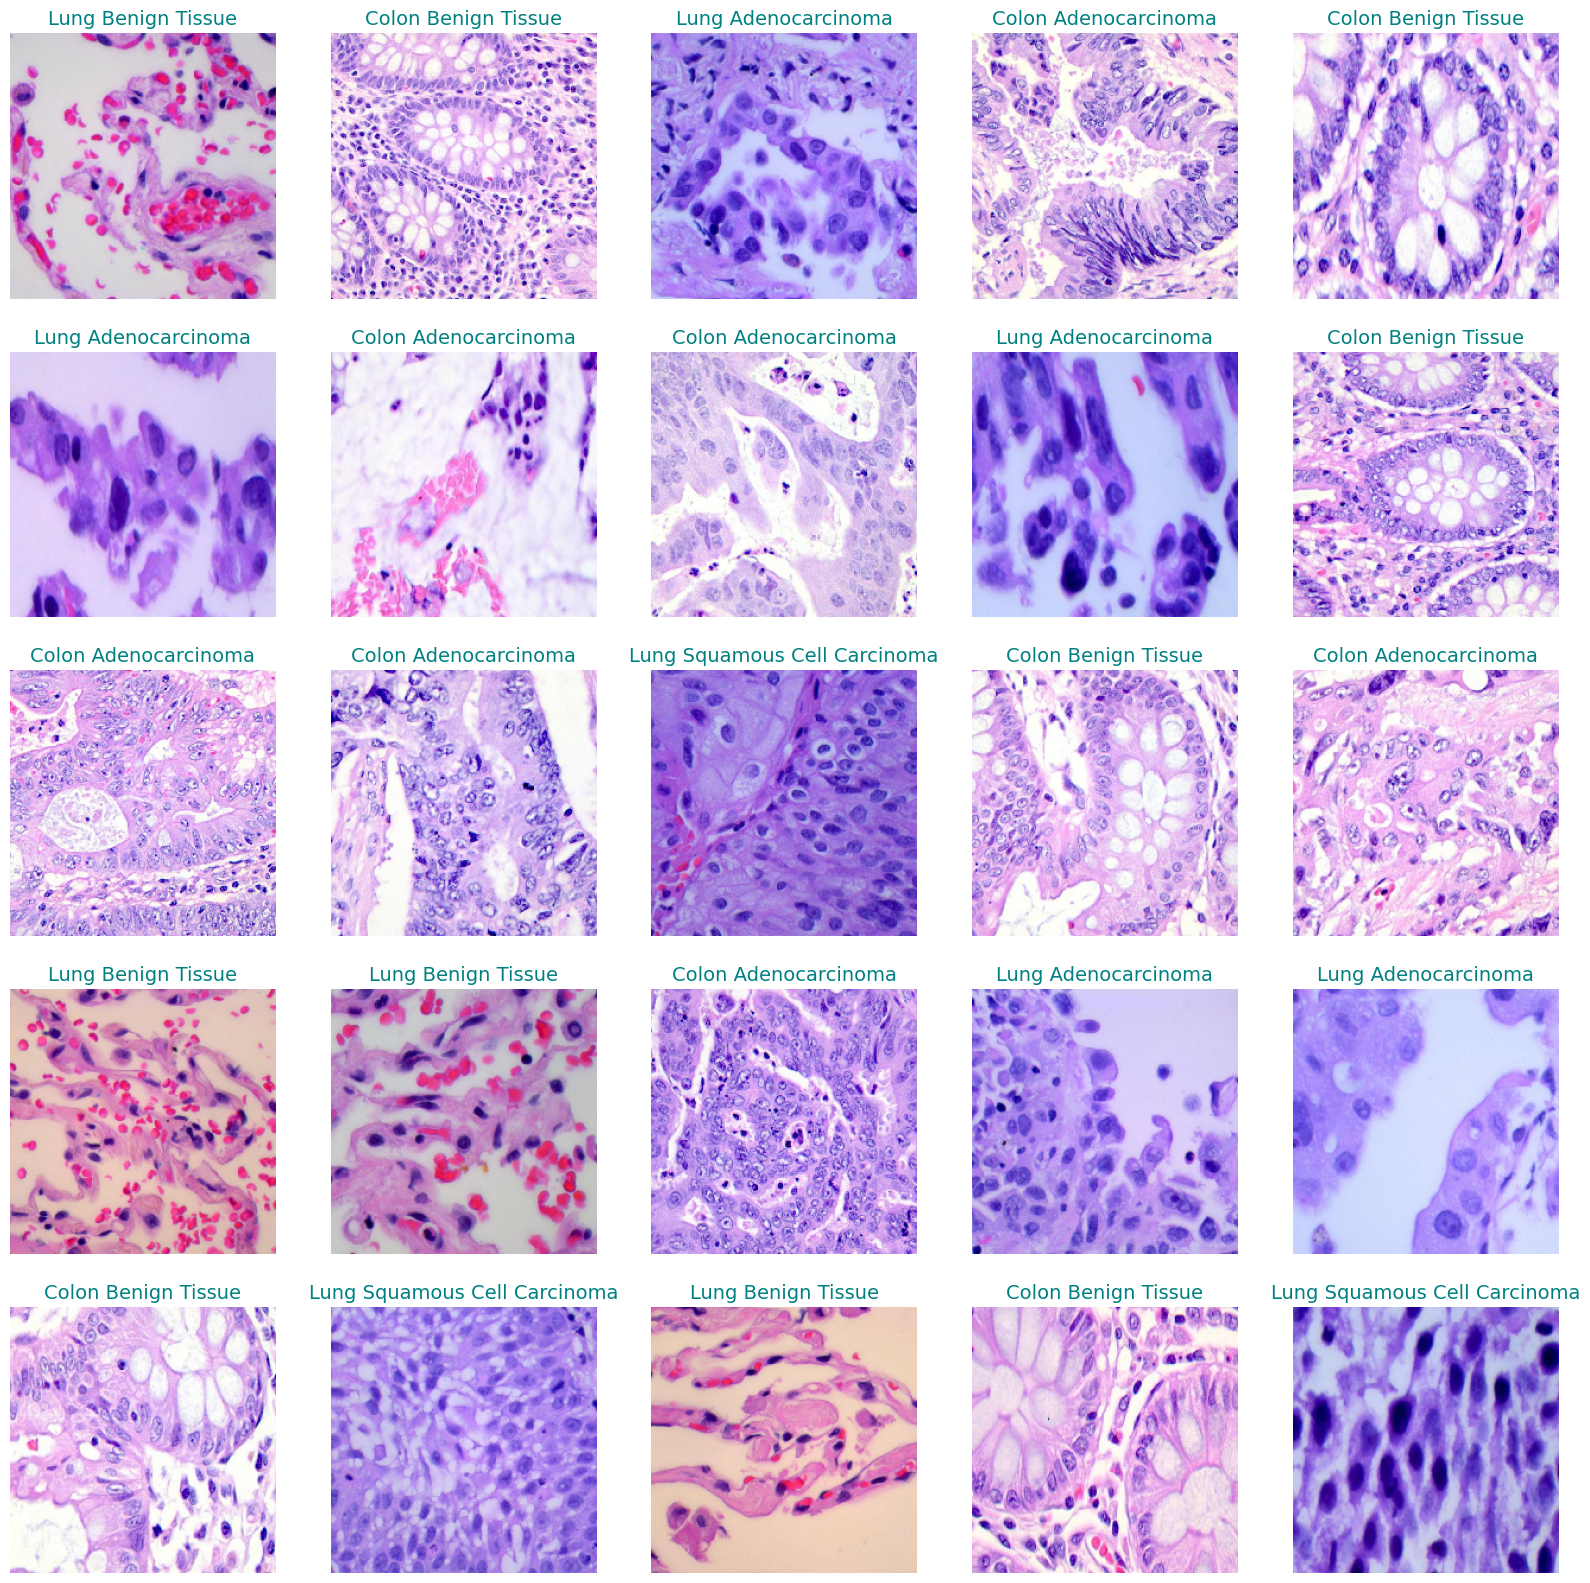

In [15]:
def image_grid(gen , train_df ):
    test_dict=gen.class_indices
    classes=list(test_dict.keys())
    images,labels=next(gen)
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i]/255)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='teal', fontsize=14)
        plt.axis('off')
    plt.show()



image_grid(train_gen, train_df)

In [16]:
class_count = len(list(train_gen.class_indices.keys()))

model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= (224,224,3)),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2,2)),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),


    Conv2D(filters=1024, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(class_count, activation = "softmax")
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy',Precision(name = 'precision'), Recall(name = 'recall'),
                                                                                        AUC(num_thresholds=200,
                                                                                           curve='ROC',
                                                                                           summation_method='interpolation',
                                                                                           name='auc'),
                                                                                        MeanAbsoluteError(name='mean_absolute_error', dtype=None),
                                                                                        MeanSquaredError(name='mean_squared_error', dtype=None),
                                                                                        RootMeanSquaredError(name='root_mean_squared_error', dtype=None)])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 56, 56, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 1024)   │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 512)    │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,125,510 (103.48 MB)

 Trainable params: 27,125,510 (103.48 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(x= train_gen, epochs= 5, validation_data= valid_gen,validation_steps= None, shuffle= False)

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-07-02 16:53:35.404688: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[64,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-02 16:53:35.798079: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 100352: 3.87759, exp

322/323 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.4332 - auc: 0.8016 - loss: 48.5914 - mean_absolute_error: 0.2115 - mean_squared_error: 0.1134 - precision: 0.5294 - recall: 0.2662 - root_mean_squared_error: 0.3348

2024-07-02 16:58:48.981010: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 2.78538, expected 2.34659
2024-07-02 16:58:48.981070: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 3.34796, expected 2.90917
2024-07-02 16:58:48.981082: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 2.93434, expected 2.49555
2024-07-02 16:58:48.981091: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 84: 2.88935, expected 2.45056
2024-07-02 16:58:48.981100: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 181: 2.93656, expected 2.49777
2024-07-02 16:58:48.981109: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 182: 3.33488, expected 2.89609
2024-07-02 16:58:48.981118: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 198: 3.2931, expected 2.8543
2024-07-02 16:58:48.981126: E external/local_xl

323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 807ms/step - accuracy: 0.4337 - auc: 0.8019 - loss: 48.4760 - mean_absolute_error: 0.2113 - mean_squared_error: 0.1133 - precision: 0.5299 - recall: 0.2668 - root_mean_squared_error: 0.3347

2024-07-02 17:00:14.923728: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50176: 3.79983, expected 3.15789
2024-07-02 17:00:14.923784: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50177: 5.13466, expected 4.49272
2024-07-02 17:00:14.923793: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50178: 4.78155, expected 4.13961
2024-07-02 17:00:14.923800: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50179: 4.88295, expected 4.24101
2024-07-02 17:00:14.923808: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50180: 4.73279, expected 4.09085
2024-07-02 17:00:14.923827: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50181: 4.69943, expected 4.05749
2024-07-02 17:00:14.923835: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50182: 4.1975, expected 3.55556
2024-07-02 17:00:14.923843: 

323/323 ━━━━━━━━━━━━━━━━━━━━ 423s 954ms/step - accuracy: 0.4341 - auc: 0.8023 - loss: 48.3613 - mean_absolute_error: 0.2112 - mean_squared_error: 0.1132 - precision: 0.5304 - recall: 0.2675 - root_mean_squared_error: 0.3346 - val_accuracy: 0.7229 - val_auc: 0.9563 - val_loss: 7.0541 - val_mean_absolute_error: 0.1133 - val_mean_squared_error: 0.0624 - val_precision: 0.7285 - val_recall: 0.7136 - val_root_mean_squared_error: 0.2499
Epoch 2/5
323/323 ━━━━━━━━━━━━━━━━━━━━ 172s 532ms/step - accuracy: 0.7071 - auc: 0.9512 - loss: 0.7145 - mean_absolute_error: 0.1265 - mean_squared_error: 0.0644 - precision: 0.7354 - recall: 0.6653 - root_mean_squared_error: 0.2533 - val_accuracy: 0.8465 - val_auc: 0.9787 - val_loss: 7.3300 - val_mean_absolute_error: 0.0681 - val_mean_squared_error: 0.0372 - val_precision: 0.8524 - val_recall: 0.8395 - val_root_mean_squared_error: 0.1930
Epoch 3/5
323/323 ━━━━━━━━━━━━━━━━━━━━ 173s 533ms/step - accuracy: 0.8472 - auc: 0.9826 - loss: 0.4623 - mean_absolute_erro

In [20]:
print(f"Training loss: {history.history['loss'][-1]:0.2f}\n")
print(f"Training accuracy: {(history.history['accuracy'][-1]*100):0.2f}%\n")
print(f"Training precision: {history.history['precision'][-1]:0.2f}\n")
print(f"Training recall: {history.history['recall'][-1]:0.2f}\n")

Training loss: 8.37

Training accuracy: 90.86%

Training precision: 0.91

Training recall: 0.90



In [19]:
print(f"Validation loss: {history.history['val_loss'][-1]:0.2f}\n")
print(f"Validation accuracy: {(history.history['val_accuracy'][-1]*100):0.2f}%\n")
print(f"Validation precision: {history.history['val_precision'][-1]:0.2f}\n")
print(f"Validation recall: {history.history['val_recall'][-1]:0.2f}\n")

Validation loss: 12.71

Validation accuracy: 91.47%

Validation precision: 0.92

Validation recall: 0.91



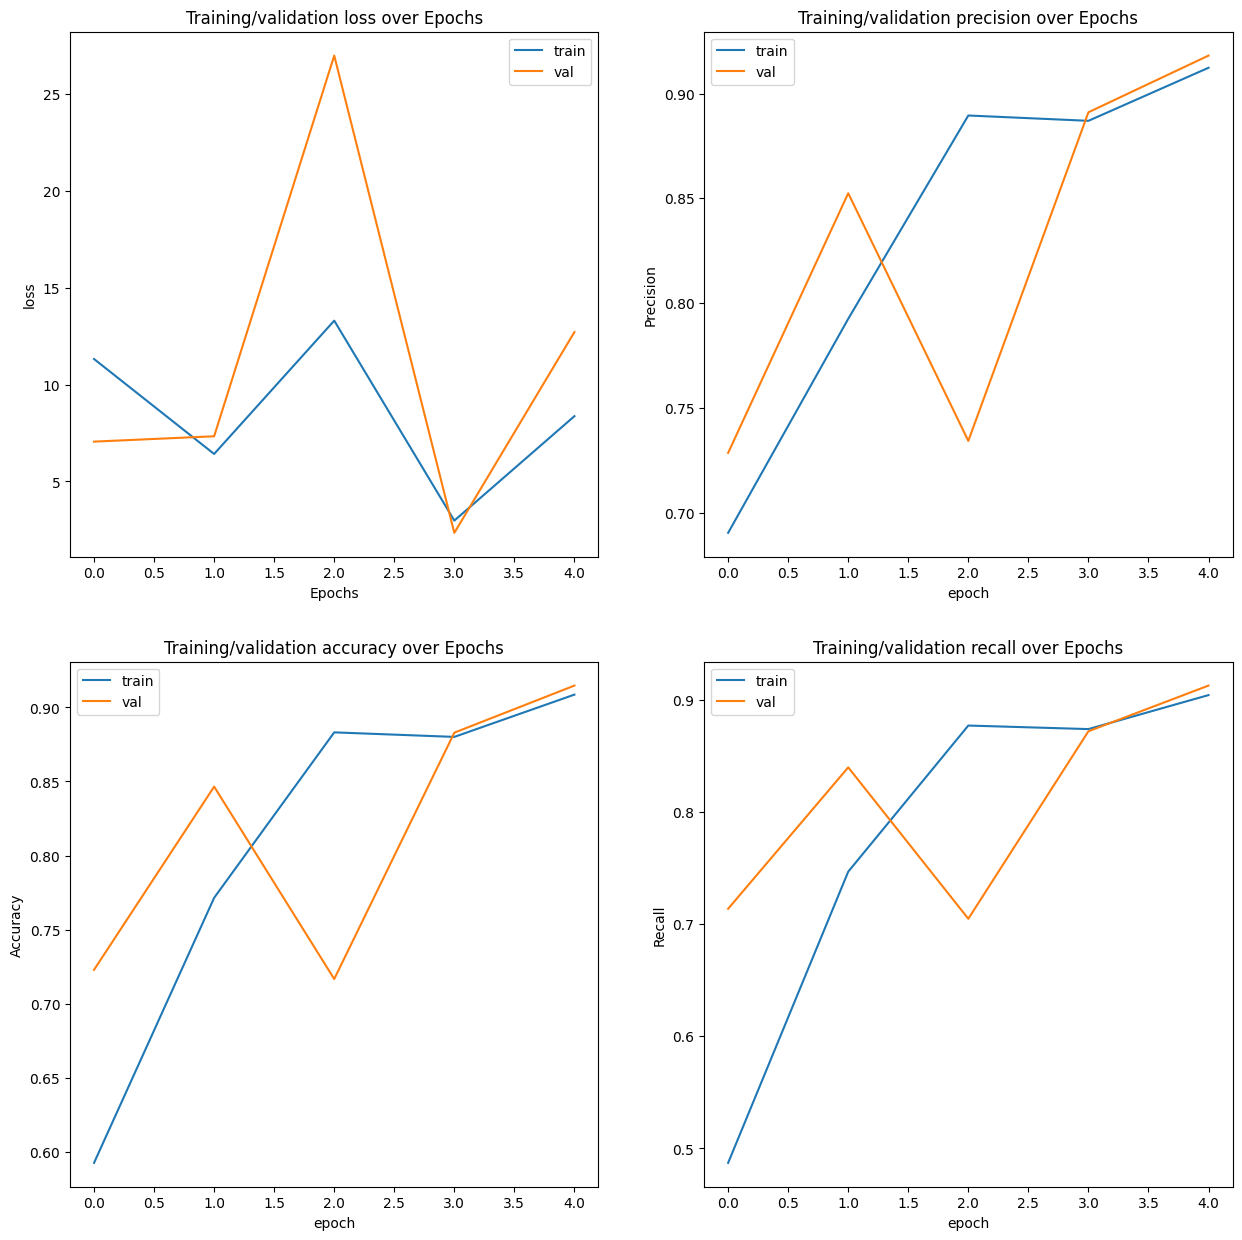

In [21]:
igure , axis = plt.subplots(2,2,figsize=(15,15))


axis[0,0].plot(history.history['loss'] , label='train')
axis[0,0].plot(history.history['val_loss'] , label='val')
axis[0,0].set_title('Training/validation loss over Epochs')
axis[0,0].set_xlabel('Epochs')
axis[0,0].set_ylabel('loss')
axis[0,0].legend()


axis[1,0].plot(history.history['accuracy'], label='train')
axis[1,0].plot(history.history['val_accuracy'], label='val')
axis[1,0].set_title('Training/validation accuracy over Epochs')
axis[1,0].set_xlabel('epoch')
axis[1,0].set_ylabel('Accuracy')
axis[1,0].legend()


axis[0,1].plot(history.history['precision'], label='train')
axis[0,1].plot(history.history['val_precision'], label='val')
axis[0,1].set_title('Training/validation precision over Epochs')
axis[0,1].set_xlabel('epoch')
axis[0,1].set_ylabel('Precision')
axis[0,1].legend()


axis[1,1].plot(history.history['recall'], label='train')
axis[1,1].plot(history.history['val_recall'], label='val')
axis[1,1].set_title('Training/validation recall over Epochs')
axis[1,1].set_xlabel('epoch')
axis[1,1].set_ylabel('Recall')
axis[1,1].legend()


In [22]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

40/89 ━━━━━━━━━━━━━━━━━━━━ 35s 724ms/step - accuracy: 0.9068 - auc: 0.9942 - loss: 0.2201 - mean_absolute_error: 0.0394 - mean_squared_error: 0.0210 - precision: 0.9091 - recall: 0.9041 - root_mean_squared_error: 0.1450

2024-07-02 17:22:04.321150: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.78283, expected 2.94933
2024-07-02 17:22:04.321208: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.74976, expected 4.91626
2024-07-02 17:22:04.321217: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.76648, expected 4.93298
2024-07-02 17:22:04.321225: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.49029, expected 4.65679
2024-07-02 17:22:04.321232: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.99986, expected 4.16636
2024-07-02 17:22:04.321240: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.68302, expected 4.84952
2024-07-02 17:22:04.321247: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.36663, expected 5.53313
2024-07-02 17:22:04.321254: E external/local_xla/xla/se

89/89 ━━━━━━━━━━━━━━━━━━━━ 45s 505ms/step - accuracy: 0.9082 - auc: 0.9916 - loss: 7.7009 - mean_absolute_error: 0.0397 - mean_squared_error: 0.0215 - precision: 0.9116 - recall: 0.9050 - root_mean_squared_error: 0.1467
Test Loss:  13.807740211486816
Test Accuracy:  0.9093374609947205


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 311ms/step


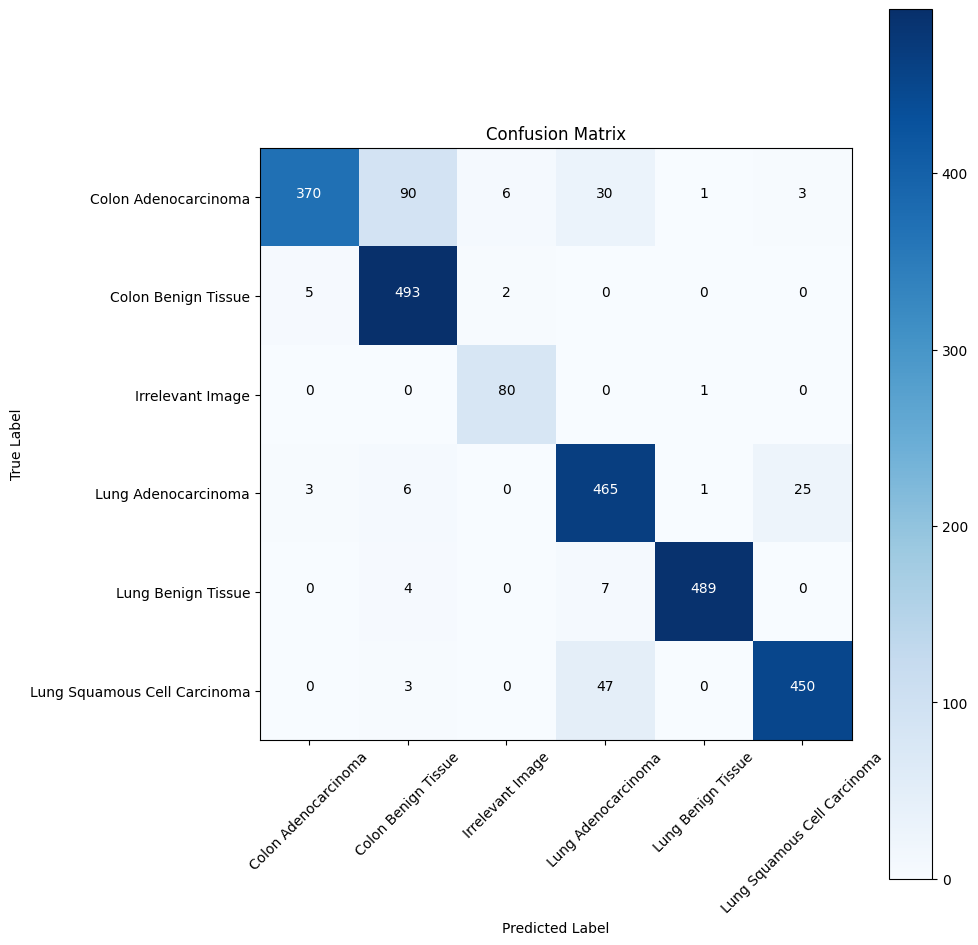

In [25]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [26]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                              precision    recall  f1-score   support

        Colon Adenocarcinoma       0.98      0.74      0.84       500
         Colon Benign Tissue       0.83      0.99      0.90       500
            Irrelevant Image       0.91      0.99      0.95        81
         Lung Adenocarcinoma       0.85      0.93      0.89       500
          Lung Benign Tissue       0.99      0.98      0.99       500
Lung Squamous Cell Carcinoma       0.94      0.90      0.92       500

                    accuracy                           0.91      2581
                   macro avg       0.92      0.92      0.91      2581
                weighted avg       0.92      0.91      0.91      2581



In [27]:
model.save('CNN_Model.h5')